#  Прогнозирование заказов такси

## Подготовка

### Загрузка библиотек

In [1]:
import time

import pandas as pd
import numpy as np
import seaborn as sns

import lightgbm

import matplotlib.pyplot as plt
# ▼ графики встраиваются в блокнот
%matplotlib inline
# ▼ векторный формат отображения
%config InlineBackend.figure_format = 'svg'

from catboost import Pool, CatBoostRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso

from sklearn.model_selection import TimeSeriesSplit

### Константы

In [2]:
# Константы проекта
DATA = ['/datasets/taxi.csv', 'https://code.s3.yandex.net/datasets/taxi.csv']

RESULT = 48 # Верхняя граница RSME, чем ниже значение тем лучше

RANDOM_STATE = 42

In [3]:
# Создадим спиcок праздников за расматриваемый периуд, чтобы выяснить взаимосвязь
HOLIDAYS_2018 = {
    '1': [], # январь
    '2': [], # февраль
    '3': [8,9,10,11], # март
    '4': [29,30], # апрель
    '5': [1,2,9], # май
    '6': [10,11,12], # июнь
    '7': [], # июль
    '8': [], # август
    '9': [], # сентябрь
    '10': [], # октябрь
    '11': [], # ноябрь
    '12': [] # декабрь
}

In [4]:
# Создадим спиcок выходных за расматриваемый периуд, чтобы выяснить взаимосвязь
DAY_OFF_2018 = {
    '1': [], # январь
    '2': [], # февраль
    '3': [3,4,17,18,24,25,31], # март
    '4': [1,7,8,14,15,21,22], # апрель
    '5': [5,6,12,13,19,20,26,27], # май
    '6': [2,3,16,17,23,24,30], # июнь
    '7': [1,7,8,14,15,21,22,28,29], # июль
    '8': [4,5,11,12,18,19,25,26], # август
    '9': [], # сентябрь
    '10': [], # октябрь
    '11': [], # ноябрь
    '12': [] # декабрь
}

### Функции

In [5]:
# EDA первичный анализ данных 
def eda(self):
    print(f'Общая информация:\n{self.info}\n\n\
shape: {self.shape}\n\n\
describe:\n{self.describe()}\n\
\nТипы данных:\n{self.dtypes}\n\
\nНаличие Nan:\n{self.isna().sum()}\n\
\nНаличие дубликатов:\n{self.duplicated().sum()}')

In [6]:
# Отрисовка графиков тренда, сезонности и остатку
def plot_tsr(data, interval=['2018-03-1','2018-08-31']):
    # data - данные
    # thirst - Дата начала
    # second  - Дата окончания
    
    decomposed = seasonal_decompose(data[interval[0]:interval[1]])
    plt.figure(figsize=(12, 8))
    plt.subplot(311)

    decomposed.trend.plot(ax=plt.gca())

    plt.title('Trend')
    plt.subplot(312)

    decomposed.seasonal.plot(ax=plt.gca())
    plt.gca()                
    plt.title('Seasonality')
    plt.subplot(313)

    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

In [7]:
# Функция создание фичь из даты
def make_features(data):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

In [8]:
# Добавим фичи отставания данных
def make_lag(data, max_lag=1, rolling_mean_size=24): # V1 изменил значения по умолчанию
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    # Добавим среднее значение ширины окна
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data.dropna(inplace=True)

In [9]:
# создадим фичи празники
def holidays_features(data):
    data['holidays'] = 0
    data['holidays'][([data.index][0].month == 3)&([data.index][0].day.isin(HOLIDAYS_2018['3']))] = 1
    data['holidays'][([data.index][0].month == 4)&([data.index][0].day.isin(HOLIDAYS_2018['4']))] = 1
    data['holidays'][([data.index][0].month == 5)&([data.index][0].day.isin(HOLIDAYS_2018['5']))] = 1
    data['holidays'][([data.index][0].month == 6)&([data.index][0].day.isin(HOLIDAYS_2018['6']))] = 1 

In [10]:
# создадим фичи выходные
def day_off_features(data):       
    data['day_off'] = 0
    data['day_off'][([data.index][0].month == 3)&([data.index][0].day.isin(DAY_OFF_2018['3']))] = 1
    data['day_off'][([data.index][0].month == 4)&([data.index][0].day.isin(DAY_OFF_2018['4']))] = 1
    data['day_off'][([data.index][0].month == 5)&([data.index][0].day.isin(DAY_OFF_2018['5']))] = 1
    data['day_off'][([data.index][0].month == 6)&([data.index][0].day.isin(DAY_OFF_2018['6']))] = 1
    data['day_off'][([data.index][0].month == 6)&([data.index][0].day.isin(DAY_OFF_2018['7']))] = 1
    data['day_off'][([data.index][0].month == 6)&([data.index][0].day.isin(DAY_OFF_2018['8']))] = 1

### Загрузка данных

In [11]:
# Загружаем данные
try:
    data = pd.read_csv(DATA[0], index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv(DATA[1], index_col=[0], parse_dates=[0])

## Анализ

In [12]:
eda(data)

Общая информация:
<bound method DataFrame.info of                      num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
...                         ...
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53

[26496 rows x 1 columns]>

shape: (26496, 1)

describe:
         num_orders
count  26496.000000
mean      14.070463
std        9.211330
min        0.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      119.000000

Типы данных:
num_orders    int64
dtype: object

Наличие Nan:
num_orders    0
dtype: int64

Наличие дубликатов:
26415


In [13]:
# Сколько значений имеют 0
print(data['num_orders'][data['num_orders'] == 0].count(),' --> ',\
      round(data['num_orders'][data['num_orders'] == 0].count() / (data.shape[0]/100),1), '%')

537  -->  2.0 %


In [14]:
# Смотрим наличие дубликатов в строках
data.duplicated().sum()

26415

In [15]:
data.groupby(data.index.month).sum()

,num_orders
datetime,
3,42768
4,45939
5,54820
6,59906
7,74405
8,94973


### Вывод №1 :

* Данные даны за пол года с интервалом в 10 мин
* Максимум такси за 10 мин 119 при среднем 9.24 (присутствуют выбросы)
* Необходимо изменить тип данных 'datetime' с object в datatype
* Провести resample 'datetime' до 1 часа
* За все время колличество заказов такси вырасло более чем в 2 раза

In [16]:
data.sort_index(inplace=True)
data_1h = data.resample('1h').sum() #сформируем данные по 1 часу
data_1d = data.resample('1d').sum() #сформируем данные по 1 дню

### Посмотрим на тренд, сезонность и остаток

Тренд, сезонность и остаток за 10-дней


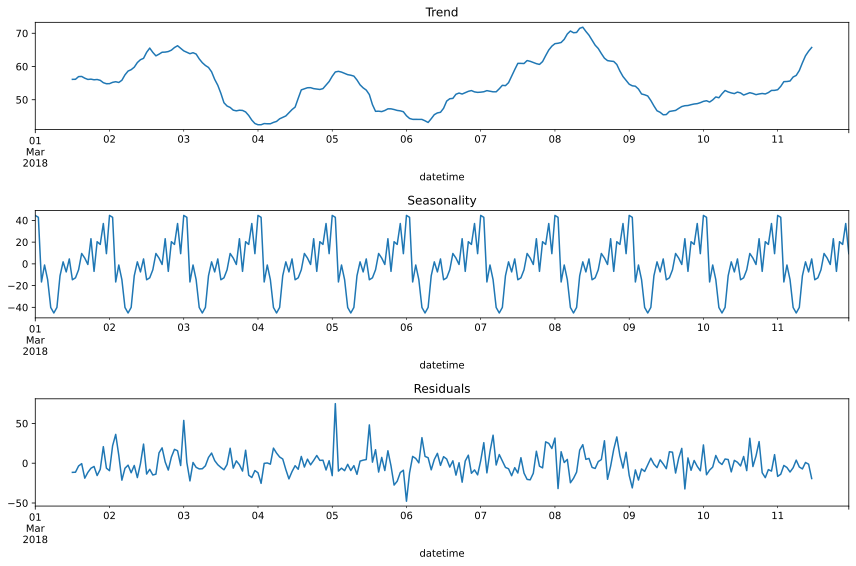

In [17]:
# за 1 день
print('Тренд, сезонность и остаток за 10-дней')
plot_tsr(data_1h,['2018-03-1','2018-03-11'])

Тренд, сезонность и остаток за 1-ый рассматриваемый месяц


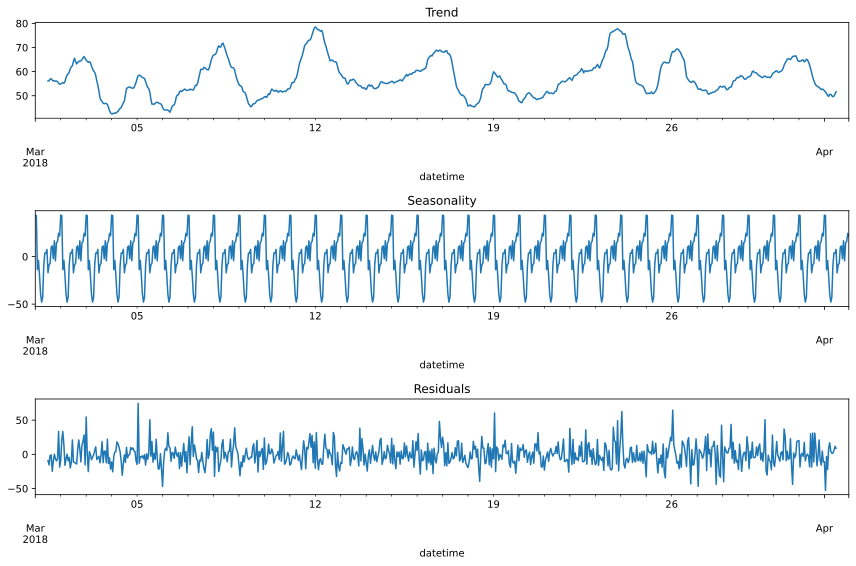

In [18]:
# По первому месяцу
print('Тренд, сезонность и остаток за 1-ый рассматриваемый месяц')
plot_tsr(data_1h,['2018-03-1','2018-04-1'])

Тренд, сезонность и остаток за последний рассматриваемый месяц


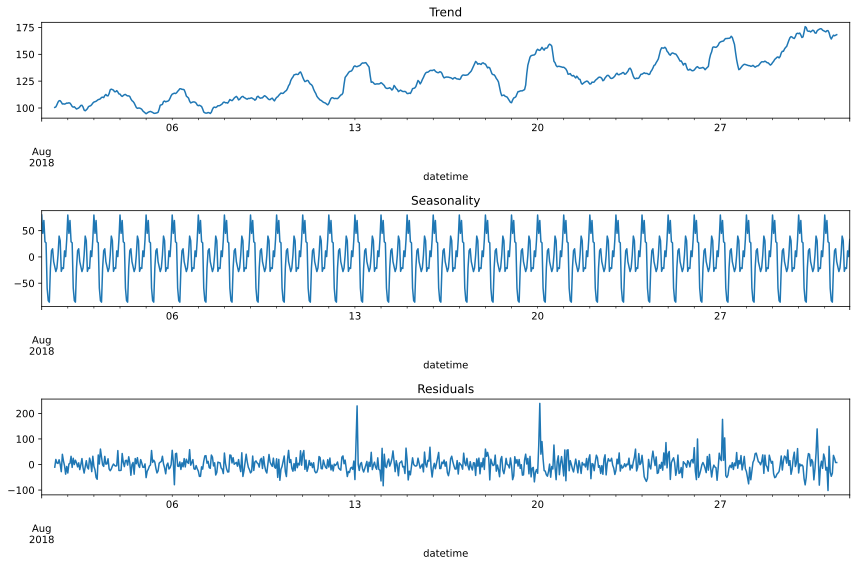

In [19]:
# По последнему месяцу
print('Тренд, сезонность и остаток за последний рассматриваемый месяц')
plot_tsr(data_1h,['2018-08-1','2018-09-1'])

Тренд, сезонность и остаток за все время


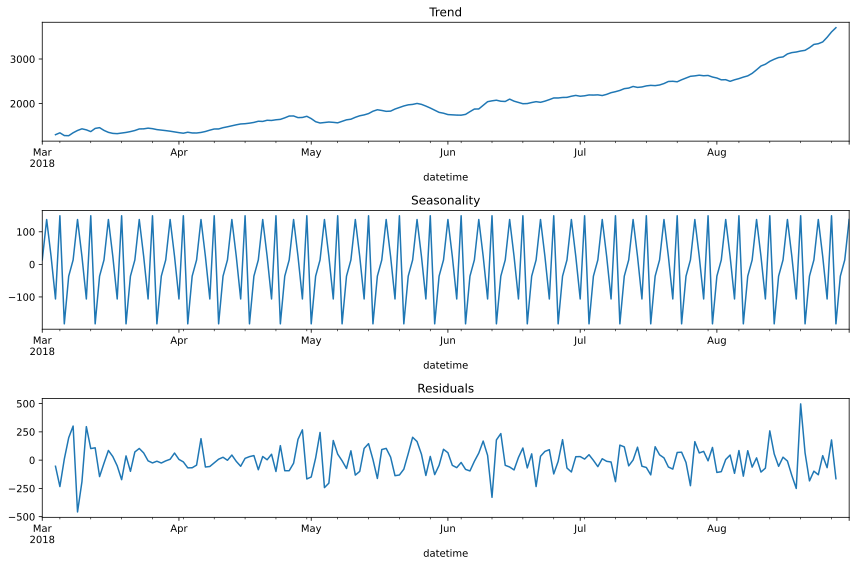

In [20]:
# За все время интервал 1 день
print('Тренд, сезонность и остаток за все время')
plot_tsr(data_1d)

### Вывод №2:

* Заметна обший тренд к увелечению заказов такси за расматриваемы периуд.
* Заметна четкий пик заказов к концу дня, и резкое падение после полуночи и до 6 утра
* Заметны пики заказов с переодичностью в 7 дней(скорей всего связано с выходными, и концом рабочей недели пятницой). Преодически правило нарушается скорей всего из за праздников.

### Создадим дополнительные фичи

In [21]:
make_features(data_1h)# Создадим фичи даты и времени по индексу

In [22]:
holidays_features(data_1h)# Создадим фичи праздники
day_off_features(data_1h)# Создадим фичи выходных (сб,вс, учтены рабочии дни из за праздников)

In [23]:
make_lag(data_1h) #(max_lag=1, rolling_mean_size=24)

In [24]:
data_1h.head(3)

,num_orders,hour,dayofweek,holidays,day_off,lag_1,rolling_mean
datetime,,,,,,,
2018-03-02 00:00:00,90,0,4,0,0,58.0,56.833333
2018-03-02 01:00:00,120,1,4,0,0,90.0,55.416667
2018-03-02 02:00:00,75,2,4,0,0,120.0,56.875000


In [25]:
data_1h.corr()

,num_orders,hour,dayofweek,holidays,day_off,lag_1,rolling_mean
num_orders,1.000000,4.184469e-03,-1.967969e-02,-9.891766e-02,-1.500459e-01,0.623635,0.553520
hour,0.004184,1.000000e+00,9.016515e-18,-1.284947e-16,-1.591366e-16,-0.076343,0.006388
dayofweek,-0.019680,9.016515e-18,1.000000e+00,-7.252786e-04,3.581621e-01,-0.027398,-0.025997
holidays,-0.098918,-1.284947e-16,-7.252786e-04,1.000000e+00,-5.172316e-02,-0.101658,-0.172405
day_off,-0.150046,-1.591366e-16,3.581621e-01,-5.172316e-02,1.000000e+00,-0.150431,-0.213468
lag_1,0.623635,-7.634273e-02,-2.739777e-02,-1.016584e-01,-1.504310e-01,1.000000,0.574792
rolling_mean,0.553520,6.388118e-03,-2.599700e-02,-1.724049e-01,-2.134684e-01,0.574792,1.000000


## Обучение

### Подготовим выборки к обучению

In [26]:
# Поделим данные на train, test
train, test = train_test_split(data_1h, shuffle=False, test_size=0.1)

In [27]:
# Смотрим за какой периуд создались выборки
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### Какие результаты показвает MAE на правильных ответах

In [28]:
# Смотрим на значения реальных ответов для сравнения
print('Средний количество заказов такси в день:', 
      round(test['num_orders'].mean()))
print('Медиана заказов такси в :', 
      round(test['num_orders'].median()))

pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]

mse_base = mean_absolute_error(test['num_orders'],
                               pred_previous['num_orders'])
print('\nMAE:', round(mse_base,3))

# Ошибка по по предыдущему
rmse_base =  mean_squared_error(test['num_orders'], 
                                pred_previous['num_orders']) ** 0.5
print('RMSE:', round(rmse_base, 3))

# Ошибка по среднему предсказанию
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE по среднему значению:", 
      round(mean_squared_error(test, pred_mean) ** 0.5, 3))

Средний количество заказов такси в день: 140
Медиана заказов такси в : 135

MAE: 44.973
RMSE: 58.882
RMSE по среднему значению: 76.306


In [29]:
print('Необходимое значение RSME <', RESULT) # Значение необходимого результата

Необходимое значение RSME < 48


Вывод:
* RMSE по предыдущему значению ближе к необходимому рзультату, возьмем этот меод за основу.

### Обучим разные модели

#### Обучим Ridge

In [30]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']

In [31]:
X_train_ridge = X_train.copy()

In [32]:
%%time
# random_state не перебирается, задаём его прямо в модели
model_ridge = Ridge(random_state=RANDOM_STATE)

# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'alpha': np.arange(0, 0.20, 0.01),
}

CPU times: user 58 µs, sys: 10 µs, total: 68 µs
Wall time: 72 µs


In [33]:
# Разделение выборки для поиска лучшей модели
tscv = TimeSeriesSplit(n_splits= 8, # 1-7, 8 неучитывается?
                       test_size= 7, # из n_split мы берем 6 значений
                       gap= 1 # из n_split мы берем 1 значение и пробум предсказать его
                      ) #(надо посмотерть, как подобрать параметр и аргументировать)

In [34]:
# Поиск лучших параметров модели
gsearch = GridSearchCV(model_ridge, 
                       param_grid= param_grid_ridge, 
                       scoring= 'neg_root_mean_squared_error',
                       n_jobs= -1, 
                       cv= tscv, 
                       verbose= 1
                      )

In [35]:
# Найдем лучшую модель
start = time.time()
gsearch.fit(X_train_ridge, y_train)
t_lean = time.time() - start
print('RSME лучшей модели:', round(-gsearch.best_score_, 2))

Fitting 8 folds for each of 20 candidates, totalling 160 fits
RSME лучшей модели: 45.9


In [36]:
result = []
# Запишем результаты модели
result.append({'Модель'                    : 'Ridge', 
               'model'                     : gsearch.best_params_,
               'Время обучения'            : round(t_lean, 3),
               'RMSE на обучающей выборке' : gsearch.best_score_ * -1,
               'На сколько лучше необходимого результата' 
                                           : round(RESULT - (gsearch.best_score_ * -1), 2)
             })
# Выведем значение результата модели
for key in result[0] : print(key, ':', result[0][key])

Модель : Ridge
model : {'alpha': 0.19}
Время обучения : 2.905
RMSE на обучающей выборке : 45.89601784521844
На сколько лучше необходимого результата : 2.1


#### Обучим LinearRegression()

In [37]:
%%time

lr = LinearRegression() # запишем модель

CPU times: user 31 µs, sys: 8 µs, total: 39 µs
Wall time: 22.9 µs


In [38]:
# словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters = {'fit_intercept':[True,False], 
              'normalize'    :[True,False], 
              'copy_X'       :[True, False]
             }

In [39]:
# Поиск лучших параметров модели
gsearch = GridSearchCV(lr,
                       param_grid = parameters, cv= tscv,
                       scoring= 'neg_root_mean_squared_error',
                       n_jobs= -1
                      )

In [40]:
# Найдем лучшую модель
start = time.time()
gsearch.fit(X_train, y_train)
t_lean = time.time() - start
print('RSME лучшей модели:', round(-gsearch.best_score_, 2))

RSME лучшей модели: 30.67


In [41]:
# Запишем результаты модели
result.append({'Модель'                    : 'LinearRegression', 
               'model'                     : lr,
               'Время обучения'            : round(t_lean,3),
               'RMSE на обучающей выборке' : -gsearch.best_score_,
               'На сколько лучше необходимого результата' 
                                           : round(RESULT + gsearch.best_score_, 2)
             })
# Выведем значение результата модели
for key in result[1] : print(key, ':', result[1][key])

Модель : LinearRegression
model : LinearRegression()
Время обучения : 0.648
RMSE на обучающей выборке : 30.67016609494774
На сколько лучше необходимого результата : 17.33


#### Обучим LightGBM

In [42]:
# Запишем основные параметры - данные
train_lgdm = lightgbm.Dataset(X_train, 
                              label = y_train, 
                              free_raw_data = False
                             )
# зараметры поиска лучшей модели
param_grid_lgbm = {'learning_rate': [0.1, 0.4, 0.7, 0.9],
                   'max_depth'    : [10, 15, 30, 60],
                  }
lgbm = lightgbm.LGBMRegressor(n_jobs = 10)

In [43]:
# Поиск лучших параметров модели
gsearch_lgbm = GridSearchCV(estimator = lgbm, 
                            param_grid= param_grid_lgbm, 
                            cv= tscv,
                            n_jobs= -1, 
                            verbose= 1,
                            scoring= 'neg_root_mean_squared_error'
                           )

In [44]:
%%time
# обучим модель
start = time.time()
gsearch_lgbm.fit(X_train, y_train)
t_lean = time.time() - start
# V1
print('RSME лучшей модели:', round(-gsearch_lgbm.best_score_, 2))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
RSME лучшей модели: 21.95
CPU times: user 2min 31s, sys: 7min 8s, total: 9min 39s
Wall time: 9min 43s


In [45]:
# Оценим модель
score_lgbm = -gsearch_lgbm.best_score_
print('Резутат RSME лучшей модели при обучение:', round(score_lgbm, 2))

Резутат RSME лучшей модели при обучение: 21.95


In [46]:
# Запишем результаты модели
result.append({'Модель'                    : 'LightGBM', 
               'model'                     : gsearch_lgbm,
               'Время обучения'            : round(t_lean, 3),
               'RMSE на обучающей выборке' : score_lgbm,
               'На сколько лучше необходимого результата' 
                                           : round(RESULT - score_lgbm, 2)
             })
# Выведем значение результата модели
for key in result[2] : print(key, ':', result[2][key])

Модель : LightGBM
model : GridSearchCV(cv=10, estimator=LGBMRegressor(n_jobs=10), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.4, 0.7, 0.9],
                         'max_depth': [10, 15, 30, 60]},
             scoring='neg_root_mean_squared_error', verbose=1)
Время обучения : 583.56
RMSE на обучающей выборке : 21.953781696188543
На сколько лучше необходимого результата : 26.05


#### Обучим CatBoostRegressor

In [61]:
# specify the training parameters 
cbr = CatBoostRegressor(iterations=2, 
                        depth=2, 
                        learning_rate=1, 
                        loss_function='RMSE'
                       )

In [55]:
# словарь с гиперпараметрами и значениями, которые хотим перебрать
parameters = {'depth'         : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [10, 20, 30]
             }

In [62]:
# Поиск лучших параметров модели
grid_cbr = GridSearchCV(estimator =  cbr, 
                        param_grid = parameters, 
                        cv= tscv, 
                        n_jobs =     -1,
                        scoring= 'neg_root_mean_squared_error'
                       )

In [64]:
start = time.time()
#train the model
grid_cbr.fit(X_train,y_train);
t_lean = time.time() - start

0:	learn: 38.7911223	total: 1ms	remaining: 9.04ms
1:	learn: 38.6506554	total: 2.11ms	remaining: 8.44ms
2:	learn: 38.5202487	total: 3.15ms	remaining: 7.34ms
3:	learn: 38.3556602	total: 4.08ms	remaining: 6.12ms
4:	learn: 38.1999304	total: 4.94ms	remaining: 4.94ms
5:	learn: 38.0395882	total: 5.99ms	remaining: 3.99ms
6:	learn: 37.8838741	total: 6.97ms	remaining: 2.99ms
7:	learn: 37.7320424	total: 7.95ms	remaining: 1.99ms
8:	learn: 37.5973153	total: 8.97ms	remaining: 996us
9:	learn: 37.4502545	total: 9.84ms	remaining: 0us
0:	learn: 31.9057925	total: 985us	remaining: 8.87ms
1:	learn: 31.7777542	total: 2.02ms	remaining: 8.1ms
2:	learn: 31.6369249	total: 2.95ms	remaining: 6.88ms
3:	learn: 31.5335387	total: 3.86ms	remaining: 5.78ms
4:	learn: 31.4044934	total: 5.05ms	remaining: 5.05ms
5:	learn: 31.2697656	total: 6.25ms	remaining: 4.17ms
6:	learn: 31.1536804	total: 7.56ms	remaining: 3.24ms
7:	learn: 31.0090099	total: 8.75ms	remaining: 2.19ms
8:	learn: 30.8836346	total: 9.57ms	remaining: 1.06ms
9:

In [70]:
score_cbr = -grid_cbr.best_score_
print('RMSE CatBoostRegressor на тестовых данных:', 
      round(score_cbr, 2))

RMSE CatBoostRegressor на тестовых данных: 31.81


In [71]:
# Запишем результаты модели
result.append({'Модель'                    : 'CatBoostRegressor', 
               'model'                     : cbr,
               'Время обучения'            : round(t_lean, 3),
               'RMSE на обучающей выборке' : score_cbr,
               'На сколько лучше необходимого результата' 
                                           : round(RESULT - score_cbr, 2)
             })
# Выведем значение результата модели
for key in result[3] : print(key, ':', result[3][key])

Модель : CatBoostRegressor
model : <catboost.core.CatBoostRegressor object at 0x7fc43646f850>
Время обучения : 32.593
RMSE на обучающей выборке : 31.811939657767226
На сколько лучше необходимого результата : 16.19


In [72]:
# Произведем тестирование наилучшей модели
result_df = pd.DataFrame(result)
result_df

,Модель,model,Время обучения,RMSE на обучающей выборке,На сколько лучше необходимого результата
0,Ridge,{'alpha': 0.19},2.905,45.896018,2.10
1,LinearRegression,LinearRegression(),0.648,30.670166,17.33
2,LightGBM,"GridSearchCV(cv=10, estimator=LGBMRegressor(n_...",583.560,21.953782,26.05
3,CatBoostRegressor,<catboost.core.CatBoostRegressor object at 0x7...,32.593,31.811940,16.19


#### Вывод:

* Лучше всего себя показала LightGBM, время обучение самое высокое

## Тестирование

### Протестирум LightGBM

In [73]:
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

In [74]:
pred = gsearch_lgbm.predict(X_test)

In [75]:
# Оценим модель
print("RMSE модели LightGBM на тестовой выборке:", 
      round(mean_squared_error(y_test, pred) ** 0.5, 3),'Необходимо <',RESULT)

RMSE модели LightGBM на тестовой выборке: 42.414 Необходимо < 48


In [76]:
pred = pd.Series(gsearch_lgbm.predict(X_test), 
                 index = y_test.index, 
                 name='preds'
                )

In [77]:
df_pred = pd.concat([y_test, pred], axis=1)
df_pred.head(5)

,num_orders,preds
datetime,,
2018-08-13 16:00:00,144,142.772187
2018-08-13 17:00:00,152,134.470522
2018-08-13 18:00:00,104,91.174831
2018-08-13 19:00:00,91,98.682566
2018-08-13 20:00:00,82,102.075479


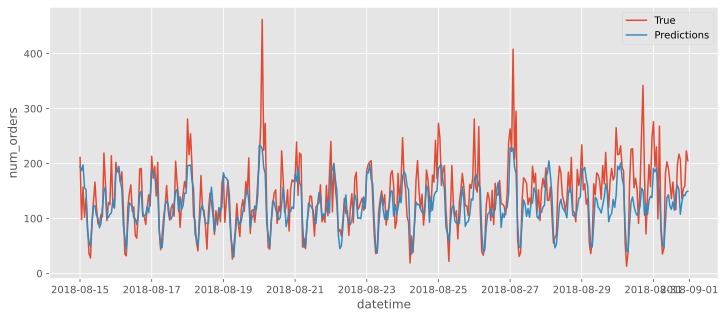

In [78]:
# Напечатаем график предсказания
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
data = df_pred['2018-08-15':]

sns.lineplot(x=data.index, 
             y=data['num_orders'], 
             label='True'
            );

sns.lineplot(x=data.index, 
             y=data['preds'], 
             label='Predictions'
            );